# Random Forest Model

## Initializing

### Imports

In [401]:
import pandas as pd
import numpy as np

In [402]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import EnglishStemmer, FrenchStemmer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 100)

from matplotlib import pyplot as plt

### Dataset check

In [403]:
#Raw dataset import
df= pd.read_csv("dataset.csv", sep=';')

In [404]:
print(df.shape)
print(list(df.columns))

(156, 72)
['ID', 'geoCountryName', 'geoLocationName', 'summary', 'industryName', 'headline', 'languages', 'publications', 'certifications', 'volunteer', 'honors', 'projects', 'exp1_locationName', 'exp1_companyName', 'exp1_description', 'exp1_title', 'exp1_startDate_month', 'exp1_startDate_year', 'exp1_industry', 'exp1_company_empl_low', 'exp2_locationName', 'exp2_companyName', 'exp2_description', 'exp2_title', 'exp2_startDate_month', 'exp2_startDate_year', 'exp2_endDate_month', 'exp2_endDate_year', 'exp2_industry', 'exp2_company_empl_low', 'exp3_locationName', 'exp3_companyName', 'exp3_title', 'exp3_description', 'exp3_startDate_month', 'exp3_startDate_year', 'exp3_endDate_month', 'exp3_endDate_year', 'exp3_industry', 'exp3_company_empl_low', 'exp4_locationName', 'exp4_companyName', 'exp4_description', 'exp4_title', 'exp4_startDate_month', 'exp4_startDate_year', 'exp4_endDate_month', 'exp4_endDate_year', 'exp4_industry', 'exp4_company_empl_low', 'exp5_locationName', 'exp5_companyName',

In [405]:
df.exp1_industry.value_counts()

Computer Software                      19
Information Technology and Services    17
Civic Social Organization              13
Government Administration              12
Management Consulting                   8
Higher Education                        8
Research                                7
International Affairs                   4
Nonprofit Organization Management       4
Internet                                3
Leisure Travel Tourism                  3
Public Relations and Communications     3
Banking                                 3
Online Media                            2
Think Tanks                             2
Renewables Environment                  2
Venture Capital Private Equity          2
Performing Arts                         2
Marketing and Advertising               2
Pharmaceuticals                         1
Farming                                 1
Design                                  1
Fine Art                                1
Insurance                         

In [406]:
len(df.exp1_industry.unique())

44

In [407]:
print(len(list(df.exp1_companyName.unique())))
print(list(df.exp1_companyName.unique()))

128
['bluenove', 'jolicode', 'cap collectif', 'change.org', 'fluicity', 'adie', 'civocracy', 'VOXE', 'abcdeep', 'sdui', 'leto', 'make.org', 'klarna', 'open source politics', 'sell - syndicat des éditeurs de logiciels de loisirs', 'freelance', 'ad education', 'nestlé france', 'analog sport', 'la cour des contes', 'malt', 'decidim', 'sloop', 'impact hub berlin', 'the one campaign', 'billy', 'institut des politiques publiques', 'egis', 'roch ventures', 'multitudes foundation', "ville d'alfortville", 'afd', 'trikoï conseil', 'google', 'sciences po ofce', 'orchestre national de jazz', 'hippocrate développement', 'sobi - swedish orphan biovitrum ab (publ)', 'capgemini invent', 'impact tank', 'ville de lyon', 'datagora', 'grandvision france', 'cour des comptes', "l'institut paris region", 'umi', 'udaf 71', 'avolta', 'university of paris i: panthéon-sorbonne', 'ville de cachan', 'edf', 'combo (ex-snapshift)', 'cerba healthcare', 'accenta.ai', 'sicoval', 'haute autorité de santé', "journaliste 

## Preparing the dataset

In [408]:
# our "y" here is the exp1_industry 
# it could be the companies but there are a lot of them (128)
# next we are going to drop everything else related to the 1st (last) experience
# ['exp1_locationName', 'exp1_companyName',
#       'exp1_description', 'exp1_title', 'exp1_startDate_month',
#       'exp1_startDate_year', 'exp1_industry', 'exp1_company_empl_low']
# as well as the ID 

In [409]:
df.set_index(['exp1_industry'], drop=True, inplace=True)
df.drop(columns=["ID", 'exp1_locationName', 'exp1_companyName',
       'exp1_description', 'exp1_title', 'exp1_startDate_month',
       'exp1_startDate_year', 'exp1_company_empl_low'], inplace=True)

In [410]:
# Now we create a list of columns as we will need to join them together in just one, with only text. 
list_df_columns= list(df.columns)
df=df.applymap(str)
df["text"] = df[list_df_columns].apply(lambda x: " ".join(x), axis =1)
df.reset_index(inplace=True)
# And we end up with a dataframe for NLP modeling 
mod_df=df[["exp1_industry", "text"]]
mod_df.head(2)


,exp1_industry,text
0,Management Consulting,France Paris Metropolitan Region Antoine croit à l’intelligence de tous et à la responsabilité d...
1,NaN,"France Paris Metropolitan Region IT Consultant, Technical Expert, Lead developer, I have an exte..."


In [411]:
# Some of the rows don't have an industry (a y) stated. 
# We are excluding them, but keeping them in a separate dataframe 
# because they could be useful to test the model later
# mod_df.isna().sum()
exp1_industry_nan= mod_df.loc[mod_df["exp1_industry"].isna()]

# So our dataframe is only the rows where the y is not null 
mod_df= mod_df.loc[mod_df["exp1_industry"].notna()]

In [412]:
# We need to remove special characters in our text column 
def clean_text_col(x):
    x=str(x)
    x= "".join(ch for ch in x if ch.isalnum() or ch==' ')
    x= x.lower()
    return x

In [413]:
mod_df["text"] = mod_df['text'].apply(clean_text_col)
mod_df.head(2)

,exp1_industry,text
0,Management Consulting,france paris metropolitan region antoine croit à lintelligence de tous et à la responsabilité de...
2,Computer Software,france paris metropolitan region nan it services and it consulting directrice des opérations che...


In [414]:
# We are here creating a top 10 of industries (because this will be useful to check our model)
top_industries= pd.DataFrame(mod_df.exp1_industry.value_counts())
top_industries.head(10)

,exp1_industry
Computer Software,19
Information Technology and Services,17
Civic Social Organization,13
Government Administration,12
Management Consulting,8
Higher Education,8
Research,7
International Affairs,4
Nonprofit Organization Management,4
Internet,3


In [415]:
# As our model needs numbers - and not text categories - to run
# We are replacing each industry with a number
# and storing the corresponding industry name in a dictionary 
factor = pd.factorize(mod_df['exp1_industry'])
mod_df.exp1_industry = factor[0]
definitions = factor[1]
print(definitions)


Index(['Management Consulting', 'Computer Software', 'Internet',
       'Information Technology and Services', 'Civic Social Organization',
       'Higher Education', 'Performing Arts', 'Marketing and Advertising',
       'Research', 'Civil Engineering', 'Venture Capital Private Equity',
       'Nonprofit Organization Management', 'Government Relations', 'Banking',
       'Education Management', 'Pharmaceuticals', 'Government Administration',
       'Information Services', 'Retail', 'Market Research',
       'Investment Banking', 'Renewables Environment', 'Hospital Health Care',
       'Chemicals', 'Human Resources', 'Public Relations and Communications',
       'International Affairs', 'Real Estate', 'Environmental Services',
       'Think Tanks', 'Farming', 'Architecture Planning',
       'Leisure Travel Tourism', 'Online Media', 'Computer Network Security',
       'Professional Training Coaching', 'Security and Investigations',
       'Restaurants', 'Telecommunications', 'Insurance'

In [416]:
mod_df.head()

,exp1_industry,text
0,0,france paris metropolitan region antoine croit à lintelligence de tous et à la responsabilité de...
2,1,france paris metropolitan region nan it services and it consulting directrice des opérations che...
3,2,france paris metropolitan region people power civic and social organizations regional director f...
4,3,france paris metropolitan region 16 years of experience driving change in the tech media indust...
5,4,france paris metropolitan region nan nonprofit organizations directrice générale adjointe chez a...


## Random Forest Classifier - standard CountVectorizer

In [417]:
# explain choice of model 
# classifier + categorical + approach 
# XGBoost would be cool for binary classification 

In [418]:
# Setting our X and Y
X= mod_df["text"]
y= mod_df["exp1_industry"]

In [419]:
#note here : there are 43 unique industries in our dataset
print(len(mod_df.exp1_industry.unique()))

43


In [420]:
# We split into training and test datasets
# Since our dataset is small, we chose a relatively small test size
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [421]:
# Vectorizing 
vectorizer = CountVectorizer()
#Checking the vector matrix 
vectors= vectorizer.fit_transform(X).todense()
vocabulary = vectorizer.get_feature_names_out()
list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)

[140, 20683]

In [422]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [423]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [424]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.5714285714285714

In [425]:
results=pd.DataFrame({"Accuracy_Score": accuracy_score(Y_test, y_pred), 
                      "Number_words": list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]},
                      index= ["RFC_raw_CVec"])
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683


In [426]:
# Making the Confusion Matrix
# Note it concentrates the predictions (not all industries are used)
pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry'])

Predicted Industry,0,1,3,4,6,16
Industry,,,,,,
0,2,0,0,0,0,0
1,0,2,0,0,0,0
3,0,1,3,0,0,0
4,0,0,0,4,0,0
5,0,0,1,0,0,0
8,0,1,0,0,0,0
16,0,0,0,0,0,1
17,0,0,1,0,0,0
19,0,1,0,0,0,0


In [427]:
#To check the results: reverse factorize (converting y from 0 ,1, 2... to industries)
reversefactor = dict(zip(range(44),definitions))
Y_test = np.vectorize(reversefactor.get)(Y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry'])


Predicted Industry,Civic Social Organization,Computer Software,Government Administration,Information Technology and Services,Management Consulting,Performing Arts
Industry,,,,,,
Architecture Planning,0,0,0,1,0,0
Civic Social Organization,4,0,0,0,0,0
Computer Software,0,2,0,0,0,0
Government Administration,0,0,1,0,0,0
Higher Education,0,0,0,1,0,0
Information Services,0,0,0,1,0,0
Information Technology and Services,0,1,0,3,0,0
Investment Banking,0,0,0,1,0,0
Leisure Travel Tourism,0,0,0,0,0,1


In [428]:
a= pd.DataFrame(pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry']))

In [429]:
a.to_csv("model1_confusion_matrix.csv", sep=';', index=True)

In [233]:
top_industries.head(10)

,exp1_industry
Computer Software,19
Information Technology and Services,17
Civic Social Organization,13
Government Administration,12
Management Consulting,8
Higher Education,8
Research,7
International Affairs,4
Nonprofit Organization Management,4
Internet,3


## Random Forest Classifier - standard CountVectorizer + balancing

In [234]:
#Note : can't use SMOTE because not enough people per class
#sm = SMOTE(random_state=100,k_neighbors=5)
#X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,Y_train)

In [235]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [236]:
# We are recreating a dataframe with our training rows to balance it (both X and y)
train = pd.concat([texts_train, Y_train],axis=1)
print(len(train.exp1_industry.unique()))
print(len(train))
#This count is actually interesting, because : 
# We had 43 original industry titles
# The training dataset only has 39 
# Which means : there are 4 industries only present in the test dataset :) 

39
119


In [237]:
# We create a dictionary which has the text as keys 
# And the category (i. e., our y) as a value 
unique_ind = train.text.unique()
ind_dict = {elem : pd.DataFrame() for elem in unique_ind}
for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

#for key, value in ind_dict.items():
#    print(value)

In [238]:
# In the dictionary are dataframes 
# And we are creating new, duplicate rows to increase the number of individuals in all the classes
# especially in the ones that are 
for key, value in ind_dict.items():
        if len(value)<16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)
len(ind_dict)
#ind_dict.values()
#ind_dict[list(ind_dict.keys())[1]]

119

In [239]:
newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

print(newtrain.columns)
print(list(newtrain.exp1_industry.value_counts()))


Index(['text', 'exp1_industry'], dtype='object')
[289, 221, 187, 153, 119, 102, 102, 68, 68, 51, 51, 51, 34, 34, 34, 34, 34, 34, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]


In [240]:
# Now we resplit our X and y
y_train_resampled = newtrain['exp1_industry'].copy()
X_train_resampled = newtrain['text'].copy()

In [241]:
# Build our vectorizer, check our matrix and build our Xs
vectorizer = CountVectorizer()
vectors= vectorizer.fit_transform(X).todense()
vocabulary = vectorizer.get_feature_names_out()
list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]

20683

In [242]:
X_train_rs = vectorizer.fit_transform(X_train_resampled)
X_test_rs = vectorizer.transform(texts_test)

In [243]:
# create and find the model 
model_rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=86)
model_rf.fit(X_train_rs, y_train_resampled)

RandomForestClassifier(class_weight='balanced_subsample', random_state=86)

In [244]:
y_pred = model_rf.predict(X_test_rs)
accuracy_score(Y_test, y_pred)

0.6666666666666666

In [246]:
# Now that we have several (although identical) individuals per class
# we can calculate the cross validation score
cv_results = cross_val_score(model_rf, X_train_rs, y_train_resampled, cv=5, scoring='accuracy')
cv_results

array([0.95802469, 1.        , 1.        , 1.        , 0.91584158])

In [247]:
results.loc["RFC_raw-balanced_CVec"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0


## Max_depth and n_estimators parameter for RFC

In [250]:
# So we have two datasets, the basic one and the resampled one. 
# The resampled one has the advantage of allowing us to perform cross-validation (although it's very theoretical)
# It has the same number of words (because it's only duplicating the same individual)
# And a slighlty better accuracy. 
# So let's try to optimize our model based on this set. 
# Random Forest parameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# We have X_train and X_train_rs
# And Y_train and Y_train_rs 
# X_test and X_test_rs 
# And Y_test 

### Max_depth

In [251]:
# Manual one parameter test for max_depth for basic dataset 
accuracies_train = []
accuracies_test = []
params_grid = list(range(1, 30))

for param_value in params_grid:
    model = RandomForestClassifier(max_depth=param_value, random_state=98)
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == Y_train))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

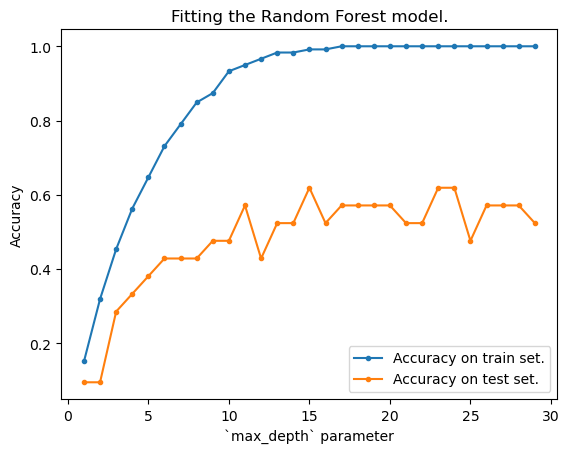

In [252]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model.')
plt.xlabel('`max_depth` parameter')
plt.ylabel('Accuracy')
plt.legend();

In [35]:
## We notice the model overfits, and there if a maximum accuracy for test set around 15

In [253]:
# If we do it for the resampled set  
accuracies_train = []
accuracies_test = []
params_grid = list(range(1, 30))

for param_value in params_grid:
    model = RandomForestClassifier(max_depth=param_value, random_state=98)
    model.fit(X_train_rs, y_train_resampled)
    Y_train_pred = model.predict(X_train_rs)
    Y_test_pred = model.predict(X_test_rs)
    accuracies_train.append(np.mean(Y_train_pred == y_train_resampled))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

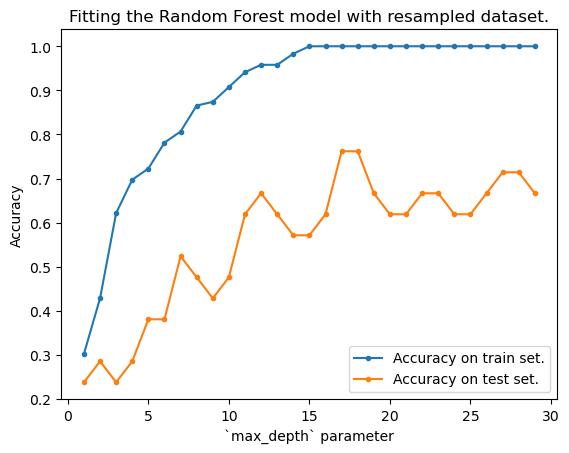

In [254]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model with resampled dataset.')
plt.xlabel('`max_depth` parameter')
plt.ylabel('Accuracy')
plt.legend();

In [255]:
# With the resampled dataset, there is also an overfitting tendency, but the optimal max depth parameter is slighly higher (around 17)

### n estimators

In [268]:
accuracies_train = []
accuracies_test = []
params_grid = [50, 75, 80, 85, 100, 125]

for param_value in params_grid:
    model = RandomForestClassifier(n_estimators=param_value, max_depth= 17, random_state=98)
    model.fit(X_train_rs, y_train_resampled)
    Y_train_pred = model.predict(X_train_rs)
    Y_test_pred = model.predict(X_test_rs)
    accuracies_train.append(np.mean(Y_train_pred == y_train_resampled))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

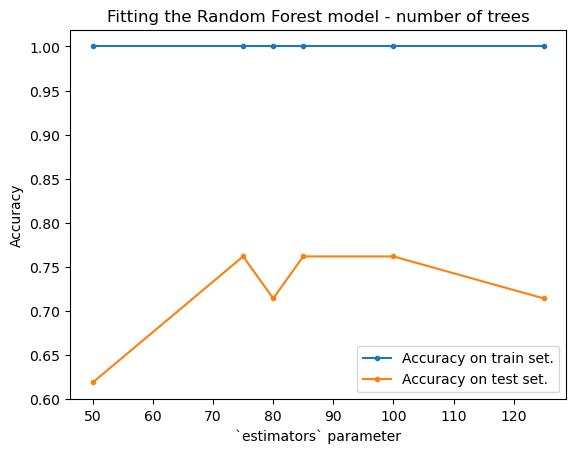

In [269]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model - number of trees')
plt.xlabel('`estimators` parameter')
plt.ylabel('Accuracy')
plt.legend();

In [262]:
# Here we see the accuracy on the test set is better around 75 trees

### Gridsearch 

In [287]:
model_rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=86)

In [288]:
# we can ask gridsearch to find our best parameters (aiming for accuracy)
# Original dataset : gridsearch doesn't work well because least populated classes have only 1 member 
# With n_estimators at 75, best score is 0.52 and max_depth recommended at 14 
# If we combine the search, we get the same results (but with best accuracy still at 0.52...)
grid_search_cv = GridSearchCV(model_rf, {'n_estimators':[25, 50, 75, 100, 125], 'max_depth': [13, 14, 15, 16, 17, 18]}, cv=3, scoring='accuracy')
grid_search_cv.fit(X_train, Y_train)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

/Users/tatianadeferaudy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0.520940170940171
{'max_depth': 14, 'n_estimators': 75}


In [290]:
# If we fit it on the resampled dataset
# it gets a far better score (0.88)
# with a recommended max depth of 18 and 125 estimators. 
# We can try pushing it farther 
# It gets a score of 0.91 with a max_depth of 20 and 175 estimators 
# although this basically means more than 1 tree per person :) 

grid_search_cv = GridSearchCV(model_rf, {
                            'n_estimators':[110, 125, 150, 175], 
                            'max_depth': [17, 18, 19, 20, 21]
                            }, 
                            cv=3, scoring='accuracy')
grid_search_cv.fit(X_train_rs, y_train_resampled)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

0.9159621936476535
{'max_depth': 20, 'n_estimators': 175}


In [291]:
#for more detail on the different tries 
# grid_search_cv.cv_results_

# Final RFC based on best parameters 

In [304]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [305]:
#Resampling 
train = pd.concat([texts_train, Y_train],axis=1)

unique_ind = train.text.unique()
ind_dict = {elem : pd.DataFrame() for elem in unique_ind}
for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

for key, value in ind_dict.items():
        if len(value)<=16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)

newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

y_train_resampled = newtrain['exp1_industry'].copy()
X_train_resampled = newtrain['text'].copy()

In [306]:
vectorizer = CountVectorizer()
vectors= vectorizer.fit_transform(X).todense()
vocabulary = vectorizer.get_feature_names_out()
list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]

20683

In [307]:
X_train_rs = vectorizer.fit_transform(X_train_resampled)
X_test_rs = vectorizer.transform(texts_test)

In [308]:
model_rf = RandomForestClassifier(n_estimators= 175, max_depth= 20, class_weight='balanced_subsample', random_state=86)
model_rf.fit(X_train_rs, y_train_resampled)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=175, random_state=86)

In [309]:
y_pred = model_rf.predict(X_test_rs)
accuracy_score(Y_test, y_pred)

0.5714285714285714

In [303]:
cv_results = cross_val_score(model_rf, X_train_rs, y_train_resampled, cv=5, scoring='accuracy')
cv_results

array([0.95802469, 0.98024691, 0.95802469, 1.        , 0.88118812])

In [310]:
results.loc["RFC_raw-balanced_CVec_BP"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0
RFC_raw-balanced_CVec_BP,0.571429,20683.0


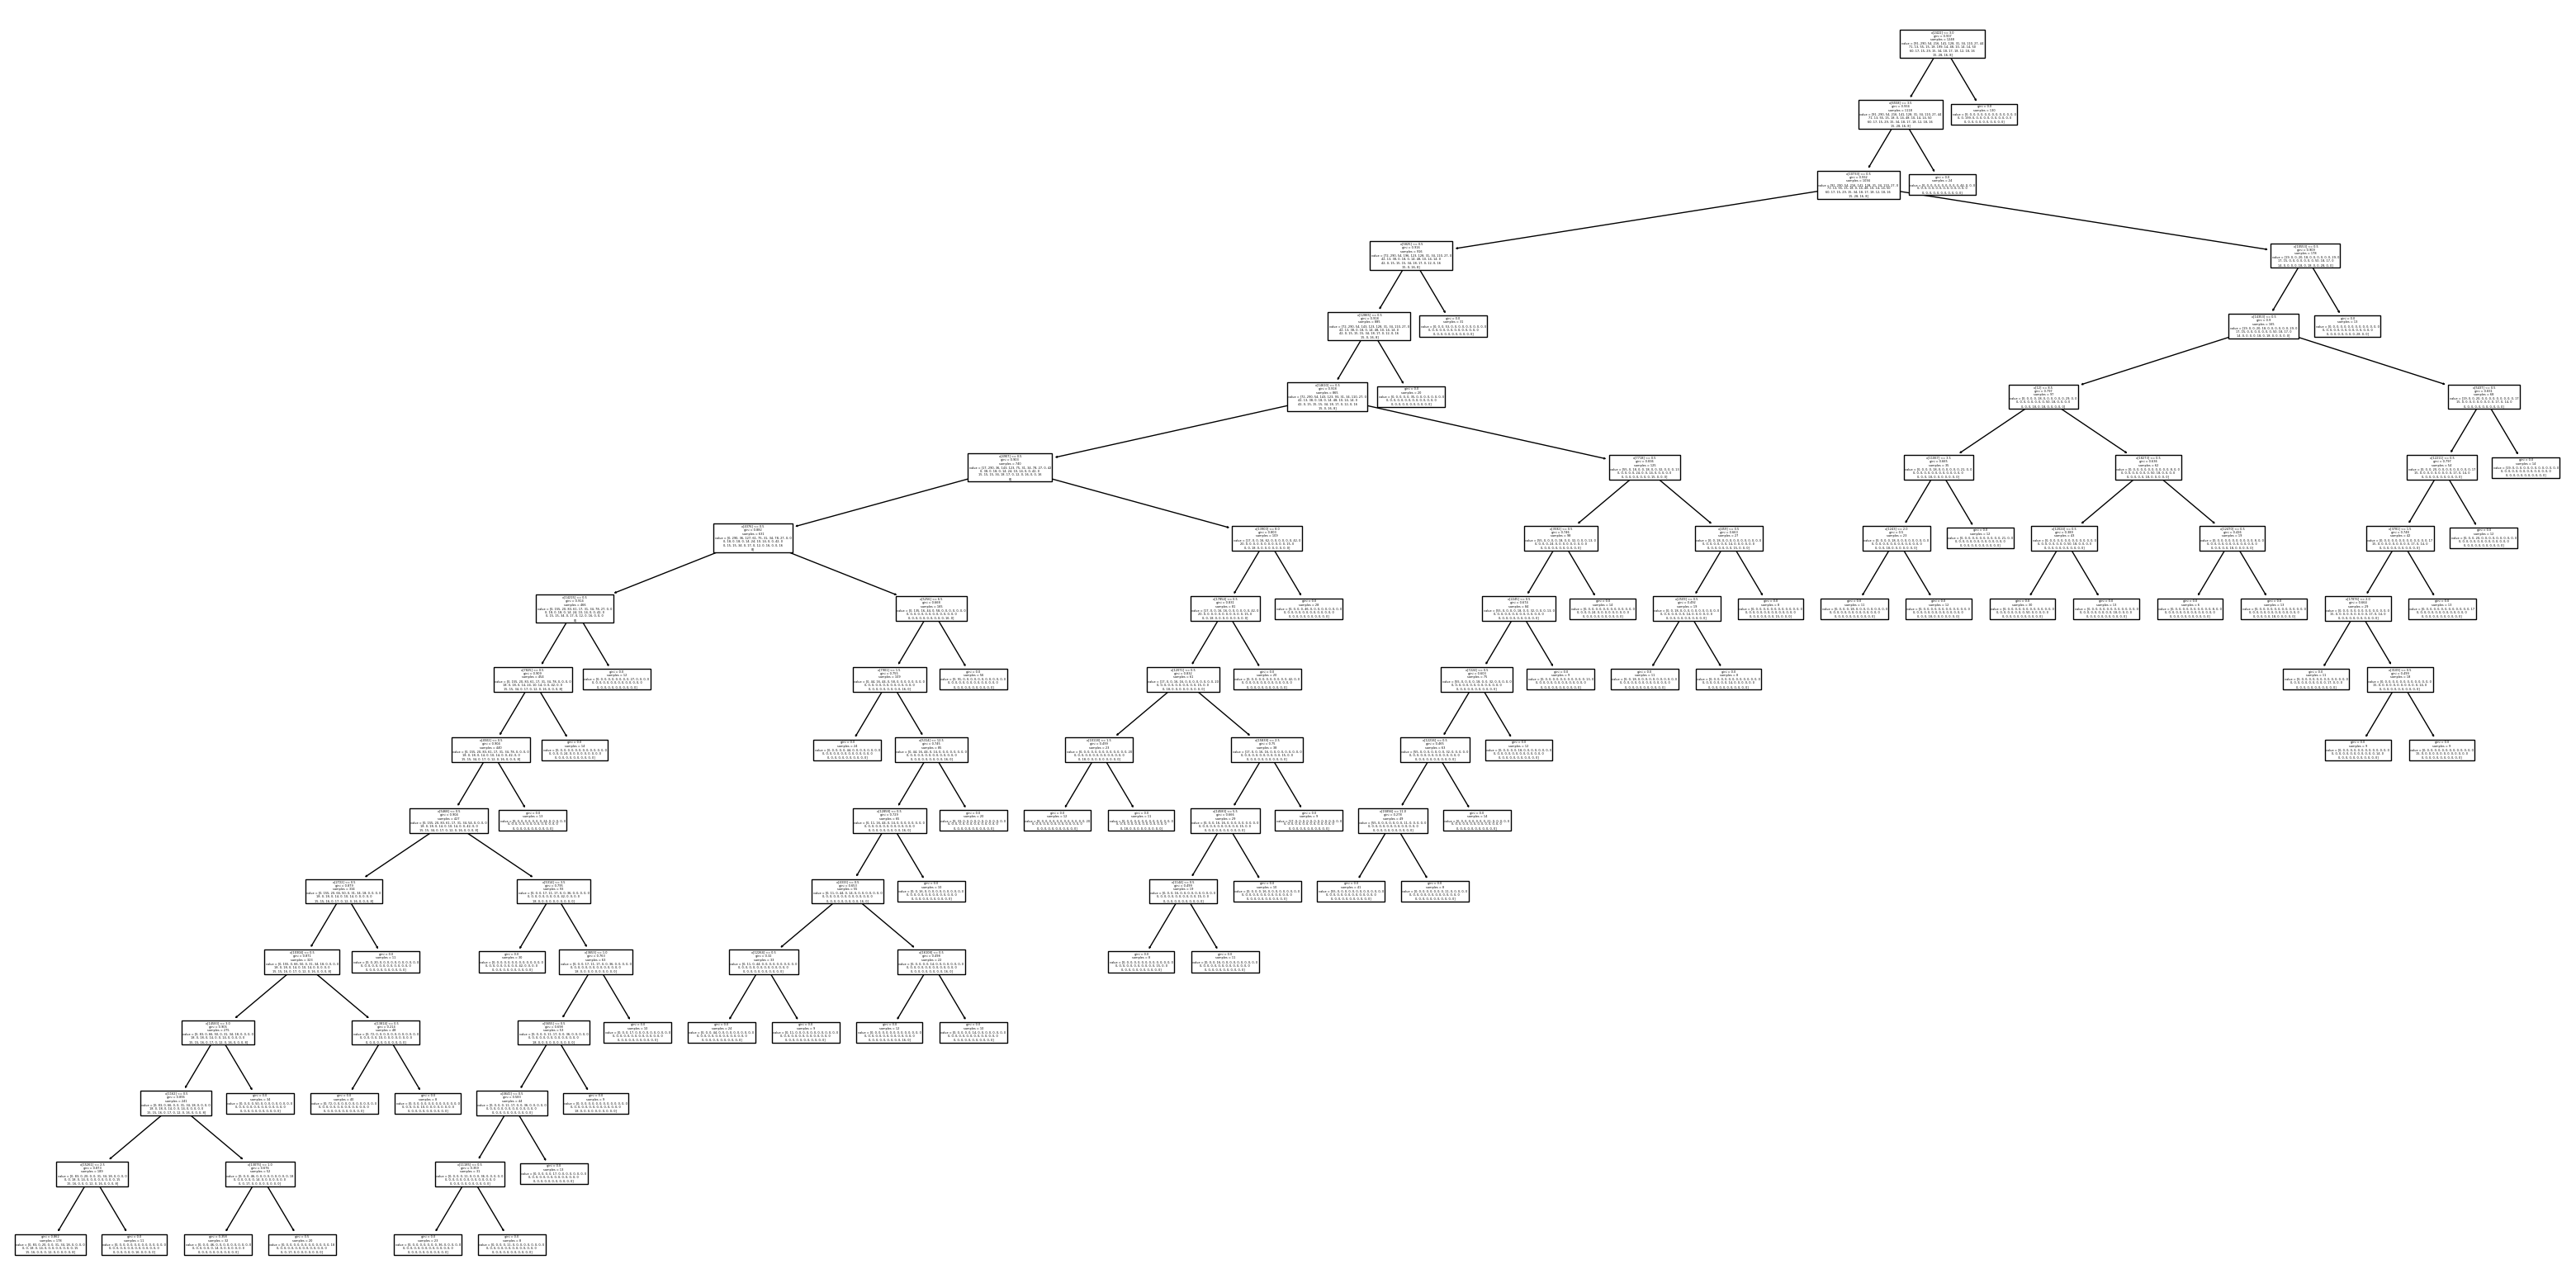

In [312]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40, 20))
plot_tree(model.estimators_[0]);

### retrying with our parameters

In [330]:
X_train_rs = vectorizer.fit_transform(X_train_resampled)
X_test_rs = vectorizer.transform(texts_test)

In [337]:
model_rf = RandomForestClassifier(n_estimators=400, max_depth=30, class_weight='balanced_subsample', random_state=86)
model_rf.fit(X_train_rs, y_train_resampled)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       n_estimators=400, random_state=86)

In [338]:
y_pred = model_rf.predict(X_test_rs)
accuracy_score(Y_test, y_pred)

0.7142857142857143

In [339]:
results.loc["RFC_raw-balanced_CVec_BmP"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0
RFC_raw-balanced_CVec_BP,0.571429,20683.0
RFC_raw-balanced_CVec_BmP,0.714286,20683.0


# Playing with the vectorizer

* Count : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* TDIF : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

### Without dealing with imbalance

In [340]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [341]:
# not using stop words because some profiles are in French and it drastically decreases accuracy 
# I could use the max_df parameter to automatically detect and filter stop words based on intra corpus document frequency of terms.
# using ngram range 1 to 2 increases accuracy - actually returns it to the normal accuracy of balanced dataset
# if we look at the word matrixes, they are actually the same (since resampling = repetition)
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectors = vectorizer.fit_transform(X).todense()

In [342]:
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 90796)

In [343]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [344]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [345]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6190476190476191

In [346]:
results.loc["RFC_CVec_E50_D17_nG"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0
RFC_raw-balanced_CVec_BP,0.571429,20683.0
RFC_raw-balanced_CVec_BmP,0.714286,20683.0
RFC_CVec_E50_D17_nG,0.619048,90796.0


### After dealing with imbalance

In [347]:
train = pd.concat([texts_train, Y_train],axis=1)

unique_ind = train.text.unique()

ind_dict = {elem : pd.DataFrame() for elem in unique_ind}

for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

for key, value in ind_dict.items():
        if len(value)<=16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)

newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

y_train_resampled = newtrain['exp1_industry'].copy()
X_train_resampled = newtrain['text'].copy()

In [348]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectors = vectorizer.fit_transform(X).todense()
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 90796)

In [349]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [355]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=30, n_estimators=400, random_state=86)

In [356]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6190476190476191

In [352]:
results.loc["RFC_CVec_balanced_E50_D17_nG"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results
# Note : even if we change the RFC parameters, the accuracy doesn't improve 

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0
RFC_raw-balanced_CVec_BP,0.571429,20683.0
RFC_raw-balanced_CVec_BmP,0.714286,20683.0
RFC_CVec_E50_D17_nG,0.619048,90796.0
RFC_CVec_balanced_E50_D17_nG,0.619048,90796.0


### Vectorizer with stemming (just for fun)

In [357]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [358]:
#stemmer = EnglishStemmer() and stemmer = FrenchStemmer() reduce accuracy
default_analyzer = CountVectorizer().build_analyzer()

In [359]:
stemmer=EnglishStemmer()

In [360]:
def analyze_with_stemming(text):
    unstemmed_words = default_analyzer(text)
    return (stemmer.stem(word) for word in unstemmed_words)

In [361]:
stemmer_vectorizer = CountVectorizer(analyzer=analyze_with_stemming)

vectors = stemmer_vectorizer.fit_transform(X).todense()
vocabulary = stemmer_vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 17726)

In [362]:
X_train = stemmer_vectorizer.fit_transform(texts_train)
X_test = stemmer_vectorizer.transform(texts_test)
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [363]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.42857142857142855

In [364]:
results.loc["RFC_CVec_E50_D17_nG_stem"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0
RFC_raw-balanced_CVec_BP,0.571429,20683.0
RFC_raw-balanced_CVec_BmP,0.714286,20683.0
RFC_CVec_E50_D17_nG,0.619048,90796.0
RFC_CVec_balanced_E50_D17_nG,0.619048,90796.0
RFC_CVec_E50_D17_nG_stem,0.428571,17726.0


### TFID (more fun) !

In [367]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [368]:
vectorizer=TfidfVectorizer()

In [369]:
vectors = vectorizer.fit_transform(X).todense()
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 20683)

In [370]:
X_train = stemmer_vectorizer.fit_transform(texts_train)
X_test = stemmer_vectorizer.transform(texts_test)
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [371]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.42857142857142855

In [372]:
results.loc["RFC_TFIDF_E50_D17"]=[accuracy_score(Y_test, y_pred), list(pd.DataFrame(vectors, columns=vocabulary, index=X).shape)[1]]
results

,Accuracy_Score,Number_words
RFC_raw_CVec,0.571429,20683.0
RFC_raw-balanced_CVec,0.666667,20683.0
RFC_raw-balanced_CVec_BP,0.571429,20683.0
RFC_raw-balanced_CVec_BmP,0.714286,20683.0
RFC_CVec_E50_D17_nG,0.619048,90796.0
RFC_CVec_balanced_E50_D17_nG,0.619048,90796.0
RFC_CVec_E50_D17_nG_stem,0.428571,17726.0
RFC_TFIDF_E50_D17,0.428571,20683.0


# Additional work

In [93]:
# Clean the columns in original dataframe to avoid getting URNs - languages, publications, etc

# Try KNN (cf. Thomas's message)
 
# remove numbers ? 
# impute industry for the missing ones 
# should some words have more weight than others ? 

# Notes for later : 
# cosine similarity instead of TDIF vectorizer ? 
# use PCA and make clusters of people 
# change the Y to 1/0 based on a civic tech list (e.g. the one that appears when creating companies SQL tables)
# work with companies' data to make clusters of similar companies and predict for that/ recommend closest neighbors (and NGOs)